## Regression Task

In [210]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes

#### Attribute Information of Sklearn Diabetes Dataset
The Sklearn Diabetes Dataset include following attributes:

- age: Age in years
- sex: Gender of the patient
- bmi: Body mass index
- bp: Average blood pressure
- s1: Total serum cholesterol (tc)
- s2: Low-density lipoproteins (ldl)
- s3: High-density lipoproteins (hdl)
- s4: Total cholesterol / HDL (tch)
- s5: Possibly log of serum triglycerides level (ltg)
- s6: Blood sugar level (glu)

Target: Column 11 represents a quantitative measure of disease progression one year after baseline.

Dataset info from https://www.geeksforgeeks.org/machine-learning/sklearn-diabetes-dataset/

In [211]:
# Load the diabetes dataset
diabetes_sklearn = load_diabetes(as_frame=True)
X, y = diabetes_sklearn['data'], diabetes_sklearn['target']

In [212]:
# Key statistics of the dataset
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


In [213]:
X.sex.unique()

array([ 0.05068012, -0.04464164])

In [214]:
X.notnull().any()

age    True
sex    True
bmi    True
bp     True
s1     True
s2     True
s3     True
s4     True
s5     True
s6     True
dtype: bool

In [215]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

**Comment:** Seems like we have 9 numerical features and one binary feature (sex). All numerical features are between 0 and 1 and we don't have any missing values.

In [216]:
# Train-Test Split
from sklearn.model_selection import train_test_split

DATASET_SIZE = len(X)
TEST_SIZE = int(0.2*DATASET_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=43)
y_train, y_test = pd.DataFrame(y_train), pd.DataFrame(y_test)

In [217]:
# Scale data (already pretty similar magnitude of features but can be good anyway)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train).reshape(-1,)

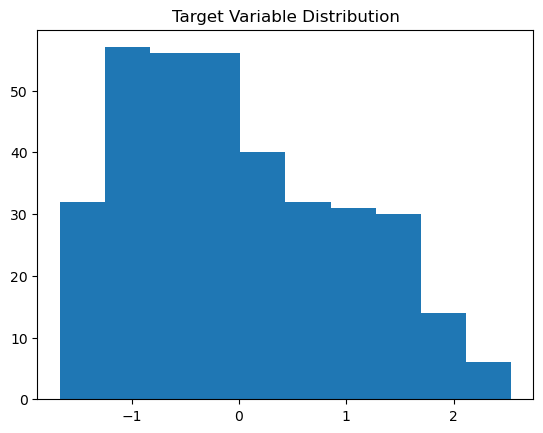

In [218]:
# Model Selection
fig = plt.figure()
plt.hist(y_train, bins='auto')
plt.title("Target Variable Distribution")
plt.show()

**Comment:** Difficult to draw any conclusions from this distribution due to the small number of samples. It looks a bit right-skewed but could also be a Gaussian, we will look at variants of standard linear regression (not Poisson regression for instance or other link functions)

In [219]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model, X_test, y_test):
    """
    Function to evaluate test metrics (mse, r2 and mae)
    """    
    X_test = scaler.transform(X_test)
    y_test = y_scaler.transform(y_test).reshape(-1,)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return {
        'Model': name,
        'MSE': mse,
        'R-squared': r2,
        'MAE': mae
    }

results = []

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
results.append(evaluate_model("Linear Regression", lr, X_test, y_test))

# Ridge Regression with hyperparameter tuning
ridge_params = {'alpha': np.logspace(-3, 3, 50)}
ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
results.append(evaluate_model(f"Ridge (alpha={ridge_cv.best_params_['alpha']:.3f})", ridge_cv.best_estimator_, X_test, y_test))

# Lasso Regression with hyperparameter tuning
lasso_params = {'alpha': np.logspace(-3, 3, 50)}
lasso_cv = GridSearchCV(Lasso(max_iter=10000), lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train, y_train)
results.append(evaluate_model(f"Lasso (alpha={lasso_cv.best_params_['alpha']:.3f})", lasso_cv.best_estimator_, X_test, y_test))

# Display results
results_df = pd.DataFrame(results)
print(results_df)

                  Model       MSE  R-squared       MAE
0     Linear Regression  0.495351   0.542070  0.589807
1  Ridge (alpha=33.932)  0.494199   0.543135  0.589785
2   Lasso (alpha=0.022)  0.498987   0.538708  0.592001


In [220]:
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

# Perform grid search with cross-validation
rf_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
)
rf_cv.fit(X_train, y_train)

# Evaluate and append results
best_rf = rf_cv.best_estimator_
results.append(evaluate_model("Random Forest", best_rf, X_test, y_test))

# Display updated results
results_df = pd.DataFrame(results)
print(results_df)

                  Model       MSE  R-squared       MAE
0     Linear Regression  0.495351   0.542070  0.589807
1  Ridge (alpha=33.932)  0.494199   0.543135  0.589785
2   Lasso (alpha=0.022)  0.498987   0.538708  0.592001
3         Random Forest  0.561015   0.481366  0.608523


In [221]:
# Hyperparameters for the best Random Forest estimator from the grid-search
print("Random Forest - Number of Trees:", rf_cv.best_estimator_.n_estimators)
print("Random Forest - Maximum Depth of a Tree:", rf_cv.best_estimator_.max_depth)
print("Random Forest - Minimum number of samples to split an internal node:", rf_cv.best_estimator_.min_samples_split)

Random Forest - Number of Trees: 100
Random Forest - Maximum Depth of a Tree: 5
Random Forest - Minimum number of samples to split an internal node: 2


#### Methodology and Analysis of Regression Task

**Methodology**. 

We began with checking some key characteristics of the dataset and found that it contained nine numerical features (all in similar range) and one binary feature (sex). We could also see that the range of values in the target variable was a lot different from the rest of the features. In the raw data, the target variable was in the order of $\sim 10^3$ while the rest of the features were in the order of $\sim 10^{-2}$.

We split the data into a training and test set. The test set consisted of 20% of the total number of samples, the size of the dataset was quite small with only 442 data points.

On the training set, we fitted a "StandardScaler" which scales the dataset by subtracting the mean and dividing by the standard deviation for each feature. Similarly, a StandardScaler was fitted on the training target values. This means that all features and the target variable will have a mean value of 0 and a standard deviation of 1. This can be useful for overall robustness of training. In cases where gradient based optimization techniques are used, the optimization landscape becomes more "uniform" which is useful. In this case we use the default solver to fit models in ```sklearn``` which is ```lbfgs``` which uses the Hessian of the loss function.

The models that are invesigated are the standard Linear Regression model, Ridge Regression, Lasso Regression and a Random Forest model. For Ridge, Lasso and Random Forest, there are hyper parameters that have to be tuned for imporved performance. The hyperparameters are tuned with Grid Search Cross Validation. This means we specify a grid of parameter values for each hyperparameter that we test. Then, for each combination of hyperparameters, Leave-One-Out-Cross-Validation is employed to get an estimate of some pre-defined metric that we want to optimize for. In this case, this metric is chosen to be the mean squared error. For Ridge Regression, the only hyperparameter is the value of $\alpha$ which scales the importance of the $l_2$-term in the loss function. For Lasso Regression, the hyperparameter is also often denoted $\alpha$ and it scales the importance of the $l_1$-term. For the Random Forest, we employ grid search on more hyperparameters, namely; the number of trees in the forest, the maximum depth of each tree and the minimum number of samples required to split an internal node.

To evaluate the models, we employ three metrics; mean squared error (MSE), $R^2$ and mean absolute error (MAE) which are all common metrics in regression tasks.

**Analysis of Results**

We can see that all models had quite similar performance, especially the three variants of regression. In the final cell output above, it can be seen that Ridge Regression have the lowest MSE and MAE and the highest $R^2$ of all models. I did however run all cells above a few times with different random seeds on the train-test-split and Ridge Regression was not consistently better than the other regression variants. Random Forest did however consistently have the higher MSE and MAE and lower $R^2$ compared to the regression models.

Overall we can see that none of the models are particularly good, keep in mind that the target values are standard scaled, this means that an MSE of about 0.5 isn't particularly impressive. The $R^2$ of the models are around 0.5 which indicates that around 50% of the variance is explained by the models. With that said, it is a quite hard task. We are predicting the progression of diabetes over a year from only 10 features from different patients, there will be a lot of variance in this data and potentially a lot of unobserved causes (features we don't have).

To improve the performance, my best guess is that more preprocessing and some feature engineering based on domain knowledge would improve results. 

## Classification Task

##### Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178

:Number of Attributes: 13 numeric, predictive attributes and the class

:Attribute Information:
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline
- class:
    - class_0
    - class_1
    - class_2


:Missing Attribute Values: None

:Class Distribution: class_0 (59), class_1 (71), class_2 (48)

:Creator: R.A. Fisher

:Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)

:Date: July, 1988

This is a copy of UCI ML Wine recognition datasets.
https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

The data is the results of a chemical analysis of wines grown in the same
region in Italy by three different cultivators. There are thirteen different
measurements taken for different constituents found in the three types of
wine.

Original Owners:

Forina, M. et al, PARVUS -
An Extendible Package for Data Exploration, Classification and Correlation.
Institute of Pharmaceutical and Food Analysis and Technologies,
Via Brigata Salerno, 16147 Genoa, Italy.

Citation:

Lichman, M. (2013). UCI Machine Learning Repository
[https://archive.ics.uci.edu/ml]. Irvine, CA: University of California,
School of Information and Computer Science.


(1) S. Aeberhard, D. Coomans and O. de Vel,
Comparison of Classifiers in High Dimensional Settings,
Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of
Mathematics and Statistics, James Cook University of North Queensland.
(Also submitted to Technometrics).

The data was used with many others for comparing various
classifiers. The classes are separable, though only RDA
has achieved 100% correct classification.
(RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data))
(All results using the leave-one-out technique)

(2) S. Aeberhard, D. Coomans and O. de Vel,
"THE CLASSIFICATION PERFORMANCE OF RDA"
Tech. Rep. no. 92-01, (1992), Dept. of Computer Science and Dept. of
Mathematics and Statistics, James Cook University of North Queensland.
(Also submitted to Journal of Chemometrics).


**Comment:** Given a dataset of chemical analysis of wines, the task is to predict from which cultivator the wine comes from. There are 3 classes (cultivators)

In [204]:
# Load Dataset
from sklearn.datasets import load_wine

wine_sklearn = load_wine(as_frame=True)
X, y = wine_sklearn['data'], wine_sklearn['target']
class_names = wine_sklearn['target_names']

In [205]:
# Train-Test Split
DATASET_SIZE = len(X)
TEST_SIZE = int(0.2*DATASET_SIZE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=14)
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

In [206]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [207]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def evaluate_classifier(name, model, X_test, y_test):
    X_test = scaler.transform(X_test)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
    print(f"\n{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return {'Model': name, 'Accuracy': acc}

results = []

# Logistic Regression with hyperparameter tuning
log_params = {'C': np.logspace(-3, 3, 10)}
log_cv = GridSearchCV(LogisticRegression(max_iter=10000, solver='liblinear'), 
                      log_params, cv=5, scoring='accuracy')
log_cv.fit(X_train, y_train)
results.append(evaluate_classifier("Logistic Regression", log_cv.best_estimator_, X_test, y_test))

# Random Forest Classifier with hyperparameter tuning
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10]
}
rf_cv = GridSearchCV(RandomForestClassifier(random_state=23), rf_params, cv=5, scoring='accuracy')
rf_cv.fit(X_train, y_train)
results.append(evaluate_classifier("Random Forest", rf_cv.best_estimator_, X_test, y_test))

# Display summary
summary_df = pd.DataFrame(results)
print("\nSummary Comparison:\n", summary_df)


Logistic Regression Accuracy: 1.0000

Logistic Regression Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        13
     class_1       1.00      1.00      1.00        16
     class_2       1.00      1.00      1.00         6

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


Logistic Regression Confusion Matrix:
 [[13  0  0]
 [ 0 16  0]
 [ 0  0  6]]

Random Forest Accuracy: 1.0000

Random Forest Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        13
     class_1       1.00      1.00      1.00        16
     class_2       1.00      1.00      1.00         6

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35


Random

=========== FULL OUTPUT FROM CELL ABOVE ==============

Logistic Regression Accuracy: 1.0000

Logistic Regression Classification Report:

                  precision    recall  f1-score   support

      class_0         1.00      1.00      1.00        13

      class_1         1.00      1.00      1.00        16
     
      class_2         1.00      1.00      1.00         6
    
      accuracy        -          -        1.00        35
   
      macro_avg       1.00      1.00      1.00        35
   
      weighted_avg    1.00      1.00      1.00        35


Logistic Regression Confusion Matrix:

 [[13  0  0]

 [ 0 16  0]

 [ 0  0  6]]

Random Forest Accuracy: 1.0000

Random Forest Classification Report:

                  precision    recall  f1-score   support

      class_0         1.00      1.00      1.00        13

      class_1         1.00      1.00      1.00        16
     
      class_2         1.00      1.00      1.00         6

    
      accuracy        -         -         1.00        35
      macro avg       1.00      1.00      1.00        35
      weighted avg    1.00      1.00      1.00        35


Random Forest Confusion Matrix:

 [[13  0  0]

 [ 0 16  0]

 [ 0  0  6]]

Summary Comparison:

               Model          Accuracy

         Logistic Regression       1.0

         Random Forest             1.0

In [209]:
# Hyperparameters of Best Estimators
print("Logistic Regression - C (Inverse Regularizing Parameter of L2-penalty)", log_cv.best_estimator_.C)
print("Random Forest - Number of Trees:", rf_cv.best_estimator_.n_estimators)
print("Random Forest - Maximum Depth of a Tree:", rf_cv.best_estimator_.max_depth)
print("Random Forest - Minimum number of samples to split an internal node:", rf_cv.best_estimator_.min_samples_split)

Logistic Regression - C (Inverse Regularizing Parameter of L2-penalty) 0.09999999999999999
Random Forest - Number of Trees: 50
Random Forest - Maximum Depth of a Tree: None
Random Forest - Minimum number of samples to split an internal node: 2


#### Methodology and Analysis of Classification Task

**Methodology**

The overall workflow was the same here as in the classification task. I'll highlight the differences in the methodologies.

The first obvious difference is that this is a classification task, meaning we are predicting a categorical variable instead of a continuous one. In this particular dataset, there are three classes that correspond to different wine cultivators.

The models that we consider in this case are Logistic Regression with an $l_2$-penalty term and a Random Forest for classification. For Logistic Regression, there is one hyperparameter to tune, the importance of the penalty term. In the Random Forest Classifier we are tuning the same hyperparameters as we did in the regression task.

The performance metrics that we analyze in classification are a bit different to the regression setting. Here, we look at the accuracy, precision, recall, f1-score and confusion matrix. For this task, we don't really have any reason to optimze for precision or recall since false negatives aren't more important than false positive or vice versa. Therefore, in the cross-validation for hyperparameter tuning, we are simply optimizing for accuracy. 

**Analysis of Results**

The result that stands out from the output of the cell above is that both classifiers obtained a test accuracy of 1.0. This dataset seems to be quite easy to classify which definetely wasn't apparent to me beforehand. I also tried to rerun all the cells (under the "Classification Task"-title) with different random seeds on the train-test-split and consistently obtained really high accuracies (often 1.0 for both models). I even tried change the train-test ratio from 0.2 to 0.5 and still got a very high accuracy.
